**HLS_script**

The objectives of this script are to:
1. Load HLS data
2. Scrape Census website for shapefiles
3. Create GeoDataFrame for shapefiles and HLS
4. Create GeoDataFrame for geocodes 
5. Plot a choropleth with HLS GeoDataFrame
6. Run OLS regression

In [23]:
## load initial packages
import pandas as pd
import geopandas as gpd
import numpy as np
import os
import re
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile

## repeated printouts
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

**1. Loading & Exploratory Visualization of HLS Data**

In [4]:
## load datasets

# website: http://healthliteracymap.unc.edu/# -> download and cite menu -> national estimates

hls = pd.read_excel("../data/HLS_data/national_hl_scores.xlsx", converters={'Census block group ID': str})
hls.head()
# len(hls)

# asserting that all block group (BG) IDs are 12 digits long
column = hls["Census block group ID"]
pattern = r'^\d{12}$'
matches = column.astype(str).str.match(pattern)

all_values_match = matches.all()
if all_values_match:
    print("All values in the column are 12 digits long.")
else:
    print("Some values in the column are not 12 digits long.")


,Census block group ID,Health literacy estimate
0,010010201001,248.91
1,010010201002,248.66
2,010010202001,233.55
3,010010202002,238.55
4,010010203001,247.96


216864

All values in the column are 12 digits long.


<Figure size 1000x600 with 0 Axes>

<AxesSubplot:xlabel='Health literacy estimate', ylabel='Density'>

Text(0.5, 0, 'Health Literacy Estimate')

Text(0, 0.5, 'Density')

Text(0.5, 1.0, 'Distribution of Health Literacy Scores')

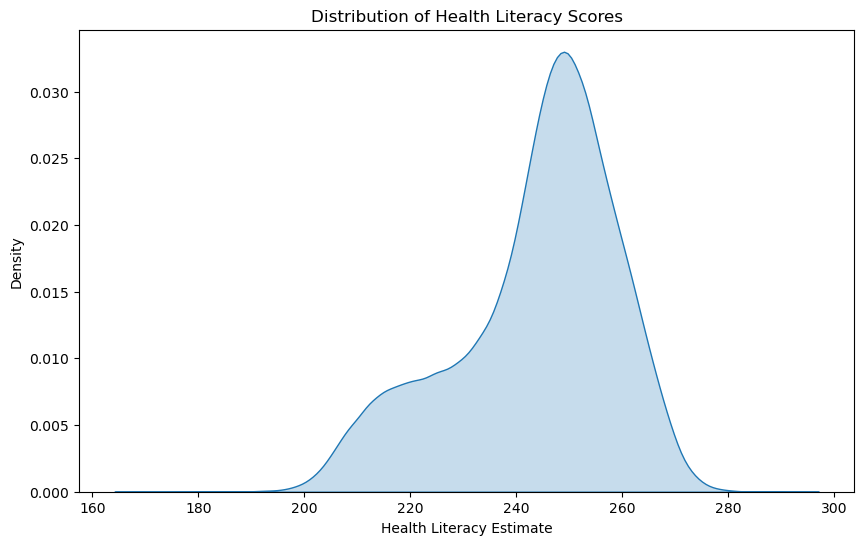

In [199]:
## density plot of HLS

plt.figure(figsize = (10, 6))
sns.kdeplot(hls['Health literacy estimate'], shade = True)
plt.xlabel('Health Literacy Estimate')
plt.ylabel('Density')
plt.title('Distribution of Health Literacy Scores')
## plt.savefig("../figures/motivation.png") # save to figures directory
plt.show()

**2. Scraping Census website for BG shapefiles**

In [4]:
## scraping Census website for shapefiles

url = "https://www2.census.gov/geo/tiger/TIGER2022/BG/"
response = requests.get(url)
zip_links = re.findall(r'href=[\'"]?([^\'" >]+\.zip)', response.text)

pattern = r'tl_2022_[0-9]{2}_bg.zip'
filtered_links = [link for link in zip_links if re.match(pattern, link)]


target_directory = "../data/mapping_data"
for link in filtered_links:
    download_url = url + link
    download_response = requests.get(download_url)
    file_path = os.path.join(target_directory, link)
    
    with open(file_path, 'wb') as file:
        file.write(download_response.content)

    with zipfile.ZipFile(file_path, 'r') as zip_ref:
        zip_ref.extractall(target_directory)

    os.remove(file_path)


In [5]:
## unzipping all shapefile .zip folders

directory = "../data/mapping_data"  # Replace with the directory containing the zip files

for file_name in os.listdir(directory):
    if file_name.endswith(".zip"):
        file_path = os.path.join(directory, file_name)

        with zipfile.ZipFile(file_path, 'r') as zip_ref:
            zip_ref.extractall(directory)

        print(f"Unzipped: {file_name}")

print("All zip files extracted successfully.")


**3. Creating GeoDataFrame of shapefiles & HLS**

In [86]:
directory = "../data/mapping_data"  # Replace with the directory containing the .shp files

combined_gdf = gpd.GeoDataFrame()

for file_name in os.listdir(directory):
    if file_name.endswith(".shp"):
        file_path = os.path.join(directory, file_name)

        gdf = gpd.read_file(file_path)

        combined_gdf = combined_gdf.append(gdf, ignore_index=True)

print("All .shp files read and combined into one GeoDataFrame.")

/var/folders/4l/ygb5zg1102qg26s9tsr84m0w0000gn/T/ipykernel_54920/1010026808.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  combined_gdf = combined_gdf.append(gdf, ignore_index=True)
/var/folders/4l/ygb5zg1102qg26s9tsr84m0w0000gn/T/ipykernel_54920/1010026808.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  combined_gdf = combined_gdf.append(gdf, ignore_index=True)
/var/folders/4l/ygb5zg1102qg26s9tsr84m0w0000gn/T/ipykernel_54920/1010026808.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  combined_gdf = combined_gdf.append(gdf, ignore_index=True)
/var/folders/4l/ygb5zg1102qg26s9tsr84m0w0000gn/T/ipykernel_54920/1010026808.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas i

/var/folders/4l/ygb5zg1102qg26s9tsr84m0w0000gn/T/ipykernel_54920/1010026808.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  combined_gdf = combined_gdf.append(gdf, ignore_index=True)
/var/folders/4l/ygb5zg1102qg26s9tsr84m0w0000gn/T/ipykernel_54920/1010026808.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  combined_gdf = combined_gdf.append(gdf, ignore_index=True)
/var/folders/4l/ygb5zg1102qg26s9tsr84m0w0000gn/T/ipykernel_54920/1010026808.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  combined_gdf = combined_gdf.append(gdf, ignore_index=True)
/var/folders/4l/ygb5zg1102qg26s9tsr84m0w0000gn/T/ipykernel_54920/1010026808.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas i

All .shp files read and combined into one GeoDataFrame.


/var/folders/4l/ygb5zg1102qg26s9tsr84m0w0000gn/T/ipykernel_54920/1010026808.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  combined_gdf = combined_gdf.append(gdf, ignore_index=True)


In [207]:
combined_gdf.head()

,STATEFP,COUNTYFP,TRACTCE,BLKGRPCE,GEOID,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,10,003,013505,1,100030135051,Block Group 1,G5030,S,1952532,0,+39.7761890,-075.7266050,"POLYGON ((-75.73943 39.77293, -75.73928 39.773..."
1,10,003,013614,2,100030136142,Block Group 2,G5030,S,1228852,0,+39.7147662,-075.6524113,"POLYGON ((-75.66302 39.72121, -75.66242 39.721..."
2,10,003,001600,2,100030016002,Block Group 2,G5030,S,96011,0,+39.7448316,-075.5537764,"POLYGON ((-75.55638 39.74458, -75.55608 39.745..."
3,10,003,011900,3,100030119003,Block Group 3,G5030,S,6520980,748739,+39.7754473,-075.6272557,"POLYGON ((-75.64591 39.79557, -75.64588 39.795..."
4,10,003,016901,1,100030169011,Block Group 1,G5030,S,21323266,0,+39.3388351,-075.6549910,"POLYGON ((-75.69185 39.33300, -75.69180 39.333..."


In [201]:
## combining mapping data with HLS data, preparing for choropleth

merged = pd.merge(combined_gdf, hls, how = "left", left_on = "GEOID", right_on = "Census block group ID")
merged.sort_values("GEOID").head()
# len(merged)


,STATEFP,COUNTYFP,TRACTCE,BLKGRPCE,GEOID,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry,Census block group ID,Health literacy estimate
193882,01,001,020100,1,010010201001,Block Group 1,G5030,S,4264299,28435,+32.4658320,-086.4896607,"POLYGON ((-86.51038 32.47225, -86.51031 32.472...",010010201001,248.91
191533,01,001,020100,2,010010201002,Block Group 2,G5030,S,5561004,0,+32.4858732,-086.4896724,"POLYGON ((-86.50461 32.47723, -86.50453 32.477...",010010201002,248.66
191545,01,001,020200,1,010010202001,Block Group 1,G5030,S,2058374,0,+32.4800823,-086.4749744,"POLYGON ((-86.48127 32.47744, -86.48126 32.477...",010010202001,233.55
191546,01,001,020200,2,010010202002,Block Group 2,G5030,S,1262444,5669,+32.4644350,-086.4697659,"POLYGON ((-86.47611 32.46765, -86.47564 32.467...",010010202002,238.55
191557,01,001,020300,1,010010203001,Block Group 1,G5030,S,3866513,9054,+32.4801750,-086.4607925,"POLYGON ((-86.47087 32.47573, -86.47084 32.475...",010010203001,247.96


242748

There are missing values in the dataframe.


**4. Creating GeoDataFrame for geocoded CHC locations**

In [9]:
## creating geodataframe for all geocodes

directory = "../data/CHC_data/geocode"  # Replace with the directory containing the .shp files

combined_geocodes = gpd.GeoDataFrame()

for file_name in os.listdir(directory):
    if file_name.endswith(".csv"):
        file_path = os.path.join(directory, file_name)

        df = pd.read_csv(file_path)

        geometry = gpd.points_from_xy(df.geometry.str.extract(r'POINT \((.*?)\)')[0].str.split().str[0].astype(float), df.geometry.str.extract(r'POINT \((.*?)\)')[0].str.split().str[1].astype(float))
        gdf = gpd.GeoDataFrame(df, geometry=geometry)

        combined_geocodes = combined_geocodes.append(gdf, ignore_index=True)

/var/folders/4l/ygb5zg1102qg26s9tsr84m0w0000gn/T/ipykernel_54920/1847173398.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  combined_geocodes = combined_geocodes.append(gdf, ignore_index=True)
/var/folders/4l/ygb5zg1102qg26s9tsr84m0w0000gn/T/ipykernel_54920/1847173398.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  combined_geocodes = combined_geocodes.append(gdf, ignore_index=True)
/var/folders/4l/ygb5zg1102qg26s9tsr84m0w0000gn/T/ipykernel_54920/1847173398.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  combined_geocodes = combined_geocodes.append(gdf, ignore_index=True)
/var/folders/4l/ygb5zg1102qg26s9tsr84m0w0000gn/T/ipykernel_54920/1847173398.py:19: FutureWarning: The frame.append method is deprecated and

In [74]:
## look into the geocode gdf, calculating data loss

# combined_geocodes.info
null = combined_geocodes.isnull().sum(axis = 1)
count_nan_rows = len(null[null > 0])

print("Number of NaN rows:", count_nan_rows)
combined_geocodes.address = combined_geocodes.address.fillna("")

<bound method DataFrame.info of                           geometry  \
0      POINT (-119.20711 36.29522)   
1                      POINT EMPTY   
2      POINT (-119.86720 36.77181)   
3                      POINT EMPTY   
4      POINT (-119.73202 36.77951)   
...                            ...   
13285                  POINT EMPTY   
13286   POINT (-73.88734 40.88132)   
13287   POINT (-73.90618 40.87754)   
13288   POINT (-73.90437 40.86435)   
13289   POINT (-73.89657 40.87026)   

                                                 address  
0      S Farmersville Blvd & Oakland St (NB), South F...  
1                                                    NaN  
2      West Clinton Avenue, 93705, Fresno, California...  
3                                                    NaN  
4      East Shields Avenue, 93726, Fresno, California...  
...                                                  ...  
13285                                                NaN  
13286  DeWitt Clinton High School, 100,

Number of NaN rows: 4092


**5. Choropleth**

<AxesSubplot:>

<AxesSubplot:>

(-130.0, -65.0)

(22.0, 50.0)

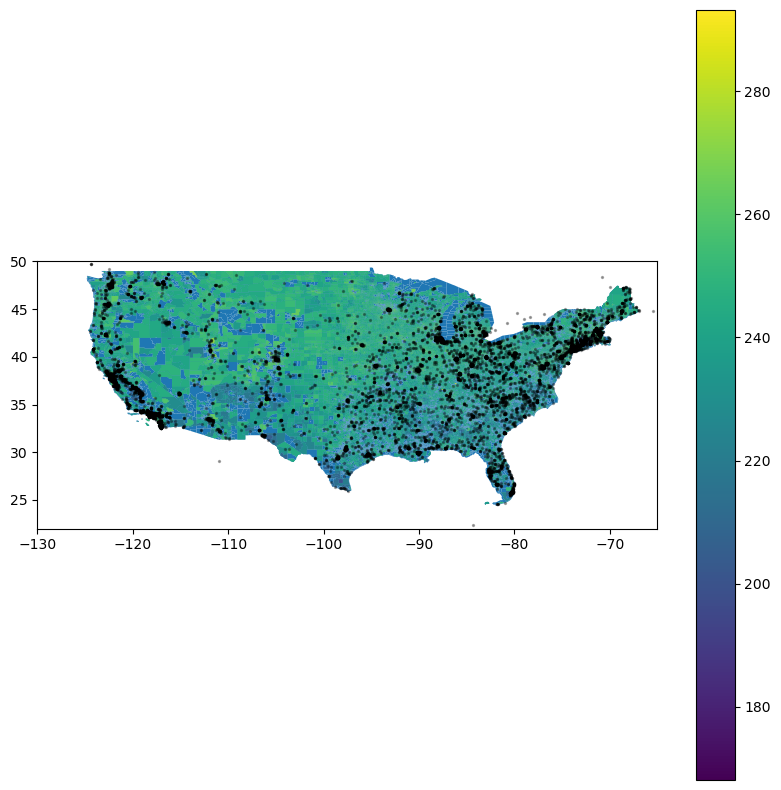

In [95]:
## plotting choropleth of US w HLS as fill

fig, ax = plt.subplots(figsize = (10, 10))
ax = merged.plot(axes=ax)
merged.plot(ax = ax, column = "Health literacy estimate", legend = True)
combined_geocodes.plot(ax = ax, color = 'black', markersize = 2, alpha = 0.3)

plt.xlim(-130, -65)
plt.ylim(22, 50)
plt.savefig('../figures/us_HLS_CHC.png')
plt.show()

In [128]:
## performing a spatial join to associate each point with its corresponding polygon
joined_data = gpd.sjoin(combined_geocodes, merged, op = 'within')
joined_data.head()

# group the data by the polygon geometry and count the number of points
point_counts = joined_data.groupby('GEOID').size()
point_counts_df = pd.DataFrame(point_counts)
point_counts_df


/Users/jessiewang/opt/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3377: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if (await self.run_code(code, result,  async_=asy)):
/var/folders/4l/ygb5zg1102qg26s9tsr84m0w0000gn/T/ipykernel_54920/1288099814.py:2: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4269

  joined_data = gpd.sjoin(combined_geocodes, merged, op = 'within')


,geometry,address,index_right,STATEFP,COUNTYFP,TRACTCE,BLKGRPCE,GEOID,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,Census block group ID,Health literacy estimate
0,POINT (-119.20711 36.29522),"S Farmersville Blvd & Oakland St (NB), South F...",118572,06,107,001601,2,061070016012,Block Group 2,G5030,S,577620,0,+36.2990864,-119.2020053,061070016012,214.65
2,POINT (-119.86720 36.77181),"West Clinton Avenue, 93705, Fresno, California...",129308,06,019,003808,3,060190038083,Block Group 3,G5030,S,647304,0,+36.7682096,-119.8667645,NaN,NaN
4,POINT (-119.73202 36.77951),"East Shields Avenue, 93726, Fresno, California...",126207,06,019,003104,2,060190031042,Block Group 2,G5030,S,9272971,40460,+36.7768768,-119.7185951,060190031042,241.11
16,POINT (-119.73202 36.77951),"East Shields Avenue, 93726, Fresno, California...",126207,06,019,003104,2,060190031042,Block Group 2,G5030,S,9272971,40460,+36.7768768,-119.7185951,060190031042,241.11
44,POINT (-119.71974 36.77601),"Fresno Yosemite International Airport, North H...",126207,06,019,003104,2,060190031042,Block Group 2,G5030,S,9272971,40460,+36.7768768,-119.7185951,060190031042,241.11


,0
GEOID,
010010211004,1
010030105001,1
010030107091,1
010030115033,1
010059502003,1
...,...
560250010002,1
560299652004,1
560299652005,3


In [200]:
## accounting for BGs with 0 CHCs, as sjoin skipped over those

df2 = pd.merge(merged, point_counts_df, how = "left", left_on = "Census block group ID", right_on = "GEOID")
df3 = pd.DataFrame(df2)
df4 = df3.copy() 
df4[0] = df4[0].fillna(0) 
df4 = df4.dropna()

# len(df4)

168251

**6. Regression**

In [203]:
## preliminary linear regression

import numpy as np
from sklearn.linear_model import LinearRegression

x = df4["Health literacy estimate"].array.reshape(-1, 1)
y = df4[0]

model = LinearRegression().fit(x, y)

r_sq = model.score(x, y)
print(f"coefficient of determination: {r_sq}")

coefficient of determination: 0.003874567734038825


Text(0.5, 1.0, 'Count of CHCs vs. Health Literacy Score')

Text(0, 0.5, 'Count of CHC in Census Group Block')

Text(0.5, 0, 'Health Literacy Score')

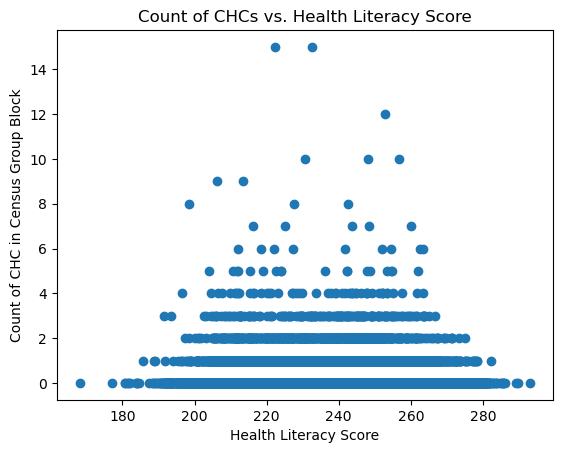

In [205]:
## plotting variables

import matplotlib.pyplot as plt

plt.scatter(x, y)
plt.title("Count of CHCs vs. Health Literacy Score")
plt.ylabel("Count of CHC in Census Group Block")
plt.xlabel("Health Literacy Score")
plt.savefig('../figures/HLS_CHCcount.png')


In [198]:
## OLS regression

import statsmodels.api as sm

y = df4[0]
x = df4["Health literacy estimate"]

x = sm.add_constant(x)

model = sm.OLS(y, x).fit()

print(model.summary())


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     654.4
Date:                Sun, 04 Jun 2023   Prob (F-statistic):          4.60e-144
Time:                        20:38:30   Log-Likelihood:                -9851.1
No. Observations:              168251   AIC:                         1.971e+04
Df Residuals:                  168249   BIC:                         1.973e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   